In [7]:
import os
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
model_name = 'sayeed99/segformer_b3_clothes'

In [3]:
# Load the image processor and the pre-trained model for semantic segmentation
processor = SegformerImageProcessor.from_pretrained(model_name)
model = AutoModelForSemanticSegmentation.from_pretrained(model_name)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the selected device

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

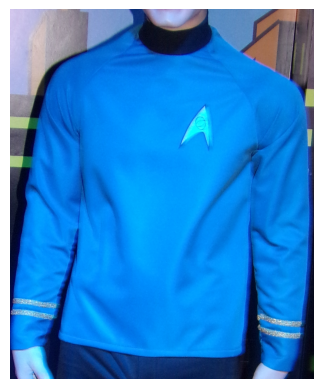

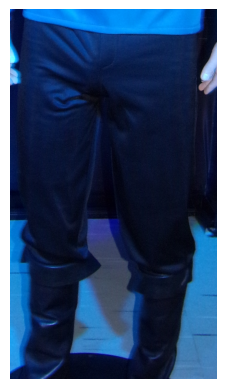

In [8]:
predict_img = '/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/detection/100_0144.JPG'

image = Image.open(predict_img)
if image.mode != "RGB":
    image = image.convert("RGB")

inputs = processor(images=image, return_tensors="pt")

# Move inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Perform inference to obtain logits from the model
outputs = model(**inputs)
logits = outputs.logits

# Upsample the logits to match the original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],  # Reverse the size to (height, width)
    mode="bilinear",
    align_corners=False,
)

# Generate segmentation map and filter valid labels
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
probabilities = nn.functional.softmax(upsampled_logits, dim=1)

certainty_mask = probabilities.max(dim=1).values > 0.7
certainty_mask_np = certainty_mask.squeeze().cpu().numpy()
valid_labels = [lbl for lbl in np.unique(pred_seg[certainty_mask_np]) if lbl in [4, 5, 6, 7]]

for label in valid_labels:
    # Convert the segmentation map to a binary mask for the target class
    target_class = label  # Define the class to be extracted
    binary_mask = (pred_seg == target_class).astype(np.uint8)

    # Find the bounding box of the target segment using non-zero indices of the binary mask
    non_zero_indices = np.nonzero(binary_mask)
    
    # Calculate the bounding box limits (min and max coordinates)
    min_y, max_y = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
    min_x, max_x = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])

    # Crop the original image using the calculated bounding box limits
    cropped_image = image.crop((min_x, min_y, max_x, max_y))

    # Display the cropped image
    plt.imshow(cropped_image)
    plt.axis("off")
    plt.show()

In [1]:
from transformers import AutoModelForSemanticSegmentation, SegformerImageProcessor
from datasets import load_dataset
import evaluate
import torch

2024-12-23 16:03:31.957540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 16:03:32.142470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 16:03:32.188093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 16:03:32.552461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 16:03:34.762489: W tensorflow/compiler/tf2

In [2]:
model_name = "sayeed99/segformer_b3_clothes"
model = AutoModelForSemanticSegmentation.from_pretrained(model_name)
processor = SegformerImageProcessor.from_pretrained(model_name)


In [3]:
dataset = load_dataset("sayeed99/fashion_segmentation")

Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/49 [00:00<?, ?it/s]

In [4]:
image_limit = 100  # Set the limit
subset = dataset["train"].select(range(image_limit))

In [5]:
# Split the dataset into 80% train and 20% test
dataset_split = dataset["train"].train_test_split(test_size=0.2)

# Access the new splits
train_dataset = dataset_split["train"]
test_dataset = dataset_split["test"]

# Limit the test dataset
subset = test_dataset.select(range(image_limit))

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 45193
    })
})

In [18]:
print(dataset["train"][0]["label"])


<PIL.PngImagePlugin.PngImageFile image mode=L size=3676x5214 at 0x7F325179E560>


In [7]:
import numpy as np
import torch

def preprocess_data(batch):
    # Ensure the segmentation mask is converted to grayscale (L mode)
    mask = batch["label"].convert("L")  # Directly use the PngImageFile object

    # Resize the mask to match the image dimensions (if necessary)
    mask = mask.resize(batch["image"].size, Image.NEAREST)  # Match input image size

    # Convert mask to numpy array
    mask_array = np.array(mask, dtype=np.int64)  # Ensure class indices are integers

    # Process the input image
    inputs = processor(images=batch["image"], return_tensors="pt", padding=True, truncation=True)

    # Add the segmentation mask
    inputs["labels"] = torch.tensor(mask_array, dtype=torch.long)
    return inputs


In [ ]:
image_limit = 100  # Limit the number of images
subset = dataset["train"].select(range(image_limit))  # Select a subset
subset = subset.map(preprocess_data)

metric = evaluate.load("mean_iou")

from torch.nn.functional import interpolate

def compute_metrics(batch):
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(pixel_values=batch["pixel_values"])
    logits = outputs.logits

    # Resize predictions to match reference dimensions
    predicted = torch.argmax(logits, dim=1)  # Get predicted class indices
    predicted_resized = interpolate(
        predicted.unsqueeze(1).float(),  # Add channel dimension
        size=batch["labels"].shape[-2:],  # Target height and width
        mode="nearest",
    ).squeeze(1).long()  # Remove channel dimension and ensure long dtype

    # Add batch to the metric
    metric.add_batch(predictions=predicted_resized, references=batch["labels"])


subset = subset.with_format("torch")
for batch in subset:
    compute_metrics(batch)

results = metric.compute(num_classes=model.config.num_labels)
print(f"Evaluation Results for {image_limit} images:", results)


In [28]:
from transformers import AutoModelForSemanticSegmentation, SegformerImageProcessor
from datasets import load_dataset
import torch
import numpy as np
from PIL import Image

# Verificar se a GPU está disponível e configurar o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo e o processador
model_name = "sayeed99/segformer_b3_clothes"
model = AutoModelForSemanticSegmentation.from_pretrained(model_name).to(device)  # Mover modelo para GPU
processor = SegformerImageProcessor.from_pretrained(model_name)


# Carregar o dataset
dataset = load_dataset("sayeed99/fashion_segmentation")

# Split the dataset into 80% train and 20% test
dataset_split = dataset["train"].train_test_split(test_size=0.2)

# Access the new splits
train_dataset = dataset_split["train"]
test_dataset = dataset_split["test"]

# Função para calcular o mIoU
def calculate_miou(preds, labels, num_classes=12):
    preds = preds.flatten()
    labels = labels.flatten()
    miou = []
    for i in range(num_classes):
        intersection = np.sum((preds == i) & (labels == i))
        union = np.sum((preds == i) | (labels == i))
        if union != 0:
            miou.append(intersection / union)
    return np.mean(miou)

# Loop sobre as imagens do dataset e calcular a performance
model.eval()
all_miou_scores = []

for example in test_dataset:
    # Processar a imagem
    image = example["image"]
    label = example["label"]
    
    # Converter a máscara (label) para NumPy
    real_mask = np.array(label)

    # Processar a imagem para o modelo
    inputs = processor(images=image, return_tensors="pt").to(device)  # Mover entradas para GPU
    
    # Obter a previsão do modelo
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

    # Garantir que predicted_mask seja do tipo uint8 e redimensioná-la
    predicted_mask = np.asarray(predicted_mask, dtype=np.uint8)

    # Redimensionar a máscara predita para o tamanho da máscara real
    predicted_mask_resized = np.array(Image.fromarray(predicted_mask).resize(real_mask.shape[::-1], Image.NEAREST))

    # Calcular a métrica de mIoU
    miou = calculate_miou(predicted_mask_resized, real_mask)
    all_miou_scores.append(miou)

# Calcular a média da mIoU
mean_miou = np.mean(all_miou_scores)
print(f"Mean mIoU: {mean_miou}")


Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/49 [00:00<?, ?it/s]

Mean mIoU: 0.14295403354992306
